# Explore the original Waymo dataset

In this notebook, we will perform an EDA (Exploratory Data Analysis) on the original Waymo dataset (downloaded data in the `raw` folder in the data directory `./data/waymo`). The data frames in the original tfrecord files contain the images of all five cameras, range images and lidar point clouds including ground truth annotations.

## Open data set tree structure of a Waymo tfrecord

The tree structure of an original Waymo tfrecord file is shown below:

```
open_dataset
|-- LaserName
|   |-- UNKNOWN
|   |-- TOP
|   |-- FRONT
|   |-- SIDE_LEFT
|   |-- SIDE_RIGHT
|   `-- REAR
|-- CameraName
|   |-- UNKNOWN
|   |-- FRONT
|   |-- FRONT_LEFT
|   |-- FRONT_RIGHT
|   |-- SIDE_LEFT
|   `-- SIDE_RIGHT
|-- RollingShutterReadOutDirection
|   |-- UNKNOWN
|   |-- TOP_TO_BOTTOM
|   |-- LEFT_TO_RIGHT
|   |-- BOTTOM_TO_TOP
|   |-- RIGHT_TO_LEFT
|   `-- GLOBAL_SHUTTER
|-- Frame
|   |-- images ⇒ list of CameraImage
|   |   |-- name (CameraName)
|   |   |-- image
|   |   |-- pose
|   |   |-- velocity (v_x, v_y, v_z, w_x, w_y, w_z)
|   |   |-- pose_timestamp
|   |   |-- shutter
|   |   |-- camera_trigger_time
|   |   `-- camera_readout_done_time
|   |-- Context
|   |   |-- name
|   |   |-- camera_calibrations ⇒ list of CameraCalibration
|   |   |   |-- name
|   |   |   |-- intrinsic
|   |   |   |-- extrinsic
|   |   |   |-- width
|   |   |   |-- height
|   |   |   `-- rolling_shutter_direction (RollingShutterReadOutDirection)
|   |   |-- laser_calibrations ⇒ list of LaserCalibration
|   |   |   |-- name
|   |   |   |-- beam_inclinations
|   |   |   |-- beam_inclination_min
|   |   |   |-- beam_inclination_max
|   |   |   `-- extrinsic
|   |   `-- Stats
|   |       |-- laser_object_counts
|   |       |-- camera_object_counts
|   |       |-- time_of_day
|   |       |-- location
|   |       `-- weather
|   |-- timestamp_micros
|   |-- pose
|   |-- lasers ⇒ list of Laser
|   |   |-- name (LaserName)
|   |   |-- ri_return1 (RangeImage class)
|   |   |   |-- range_image_compressed
|   |   |   |-- camera_projection_compressed
|   |   |   |-- range_image_pose_compressed
|   |   |   `-- range_image
|   |   `-- ri_return2 (same as ri_return1)
|   |-- laser_labels ⇒ list of Label
|   |-- projected_lidar_labels (same as camera_labels)
|   |-- camera_labels ⇒ list of CameraLabels
|   |   |-- name (CameraName)
|   |   `-- labels ⇒ list of Label
|   `-- no_label_zones (Refer to the doc)
`-- Label
    |-- Box
    |   |-- center_x
    |   |-- center_y
    |   |-- center_z
    |   |-- length
    |   |-- width
    |   |-- height
    |   `-- heading
    |-- Metadata
    |   |-- speed_x
    |   |-- speed_y
    |   |-- accel_x
    |   `-- accel_y
    |-- type
    |-- id
    |-- detection_difficulty_level
    `-- tracking_difficulty_level
```

In [1]:
import os
import tensorflow as tf
import math
import numpy as np
import itertools
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
#Used for creating the bouding boxes
import matplotlib.patches as patches

# Enable TensorFlow eager execution mode
tf.compat.v1.enable_eager_execution()

# Import waymoe open dataset utils
from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

from utils import get_dataset
from utils import get_label_map

In [2]:
%matplotlib inline

In [3]:
# get object category index and object classname index
category_idx, classname_idx = get_label_map(label_map_path='./label_map.pbtxt')
print("Object category index:     {}".format(category_idx))
print("Object classname index:    {}".format(classname_idx))

# get number of availabel object classes
num_of_object_classes = len(category_idx)
print("Number of object classes:  {}".format(num_of_object_classes))

Object category index:     {1: 'vehicle', 2: 'pedestrian', 4: 'cyclist'}
Object classname index:    {'vehicle': 1, 'pedestrian': 2, 'cyclist': 4}
Number of object classes:  3


In [4]:
#class_color_idx = {1: [0, 0, 1], 2: [1, 0, 0], 4: [0, 1, 0]}
class_color_idx = {1: u'#1f77b4', 2: u'#ff7f0e', 4: u'#2ca02c'}
# create an array with class-based colors
custom_colors = list(class_color_idx.values())
# define custom color palette
custom_color_palette = sns.set_palette(sns.color_palette(custom_colors))

## Load Raw Data Set from TFRecord Files

In [5]:
tfrecord_path = "./data/waymo/raw/"
tfrecord_filelist = os.listdir(tfrecord_path)
print("Number of tfrecord files in filelist: {}".format(len(tfrecord_filelist)))

Number of tfrecord files in filelist: 100


In [6]:
def get_statistics_from_tf_data_set(tfrecord_path, tfrecord_filelist, classname_idx):
    """ Get ground truth label statistics from a dataset for object detection
        in color images contained in a set of tfrecord files.
    
    Args:
        tfrecord_path [str]: filepath to the tfrecord file storage location
        tfrecord_filelist [list]: list of tfrecord files to be evaluated
        classname_idx [dict]: object class name index by object class name
    
    Returns:
        [pandas.DataFrame]: dataframe holding the frame statistics
    """
    # column names for frame statistics
    frame_stats_columns = [
        'tfrecord_index',
        'tfrecord_id',
        'frame_index',
        'location',
        'time_of_day',
        'weather',
        'num_of_vehicles',
        'num_of_pedestrians',
        'num_of_cyclists',
    ]
    # init list of frame statistics
    frame_stats = []
    # number of tfrecord files to be evaluated
    num_of_files = len(tfrecord_filelist)
    # loop over all tfrecord files in the given directory
    for tfrecord_idx, tfrecord_file in enumerate(tfrecord_filelist):
        # load data set from the current tfrecord file
        dataset = tf.data.TFRecordDataset(os.path.join(tfrecord_path, tfrecord_file), compression_type='')
        # loop over all frames in the current data set and count the number of frames in tfrecord file
        for frame_idx, data in enumerate(dataset):
            # open next data frame
            frame = open_dataset.Frame()
            # convert the byte array to numpy dictionary
            frame.ParseFromString(bytearray(data.numpy()))
            # count the labeled object per frame and per class
            obj_cnts_vehicles = 0
            obj_cnts_pedestrians = 0
            obj_cnts_cyclists = 0
            for obj_cnts in frame.context.stats.camera_object_counts:
                if obj_cnts.type == classname_idx['vehicle']:
                    obj_cnts_vehicles = obj_cnts.count
                if obj_cnts.type == classname_idx['pedestrian']:
                    obj_cnts_pedestrians = obj_cnts.count 
                if obj_cnts.type == classname_idx['cyclist']:
                    obj_cnts_cyclists = obj_cnts.count
            # append evaluation results to list of frame statistics
            frame_stats.append([
                tfrecord_idx,
                frame.context.name,
                frame_idx,
                frame.context.stats.location,
                frame.context.stats.time_of_day,
                frame.context.stats.weather,
                obj_cnts_vehicles,
                obj_cnts_pedestrians,
                obj_cnts_cyclists,
            ])
        
        # count number of frames per tfrecord
        num_of_frames = frame_idx + 1
        
        # print tfrecord file name incl. number of contained frames
        print("tfrecord index: {} of {}".format(tfrecord_idx, num_of_files))
        print("tfrecord file: {}".format(tfrecord_file))
        print("number of frames: {}".format(num_of_frames))

    # create and return data frame holding the frame statistics
    return pd.DataFrame(frame_stats, columns=frame_stats_columns)

In [7]:
# get the frame statistics from tfrecord files
df_frame_stats = get_statistics_from_tf_data_set(tfrecord_path, tfrecord_filelist, classname_idx)
print(df_frame_stats.head())

tfrecord index: 0 of 100
tfrecord file: segment-11379226583756500423_6230_810_6250_810_with_camera_labels.tfrecord
number of frames: 198
tfrecord index: 1 of 100
tfrecord file: segment-11388947676680954806_5427_320_5447_320_with_camera_labels.tfrecord
number of frames: 198
tfrecord index: 2 of 100
tfrecord file: segment-10072231702153043603_5725_000_5745_000_with_camera_labels.tfrecord
number of frames: 198
tfrecord index: 3 of 100
tfrecord file: segment-11718898130355901268_2300_000_2320_000_with_camera_labels.tfrecord
number of frames: 198
tfrecord index: 4 of 100
tfrecord file: segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord
number of frames: 198
tfrecord index: 5 of 100
tfrecord file: segment-10153695247769592104_787_000_807_000_with_camera_labels.tfrecord
number of frames: 198
tfrecord index: 6 of 100
tfrecord file: segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord
number of frames: 199
tfrecord index: 7 of 100
tfrecord file: segme

tfrecord index: 60 of 100
tfrecord file: segment-11489533038039664633_4820_000_4840_000_with_camera_labels.tfrecord
number of frames: 199
tfrecord index: 61 of 100
tfrecord file: segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord
number of frames: 199
tfrecord index: 62 of 100
tfrecord file: segment-10327752107000040525_1120_000_1140_000_with_camera_labels.tfrecord
number of frames: 198
tfrecord index: 63 of 100
tfrecord file: segment-10275144660749673822_5755_561_5775_561_with_camera_labels.tfrecord
number of frames: 198
tfrecord index: 64 of 100
tfrecord file: segment-10075870402459732738_1060_000_1080_000_with_camera_labels.tfrecord
number of frames: 199
tfrecord index: 65 of 100
tfrecord file: segment-11799592541704458019_9828_750_9848_750_with_camera_labels.tfrecord
number of frames: 199
tfrecord index: 66 of 100
tfrecord file: segment-10723911392655396041_860_000_880_000_with_camera_labels.tfrecord
number of frames: 198
tfrecord index: 67 of 100
tfrecord f

In [8]:
# total number of frames in the data set
total_num_of_frames = len(df_frame_stats)
print("\nTotal number of frames: {}\n".format(total_num_of_frames))


Total number of frames: 19803



### Object classes and object counts

In [9]:
# get total number of labeled objects in the data set
object_classes = ['vehicle', 'pedestrian', 'cyclist']
object_counts = [
    df_frame_stats.num_of_vehicles.sum(),
    df_frame_stats.num_of_pedestrians.sum(),
    df_frame_stats.num_of_cyclists.sum()
]
object_percentage = np.array(object_counts) / sum(object_counts) * 100
# Print results
print('Total number of labeled objects in the data set:')
print("- Vehicles: {0} ({1:5.2f}%)".format(object_counts[0], object_percentage[0]))
print("- Pedestrians: {0} ({1:5.2f}%)".format(object_counts[1], object_percentage[1]))
print("- Cyclists: {0} ({1:5.2f}%)".format(object_counts[2], object_percentage[2]))
print("- Objects: {0} (100%)".format(sum(object_counts)))

Total number of labeled objects in the data set:
- Vehicles: 769102 (74.42%)
- Pedestrians: 258642 (25.03%)
- Cyclists: 5732 ( 0.55%)
- Objects: 1033476 (100%)


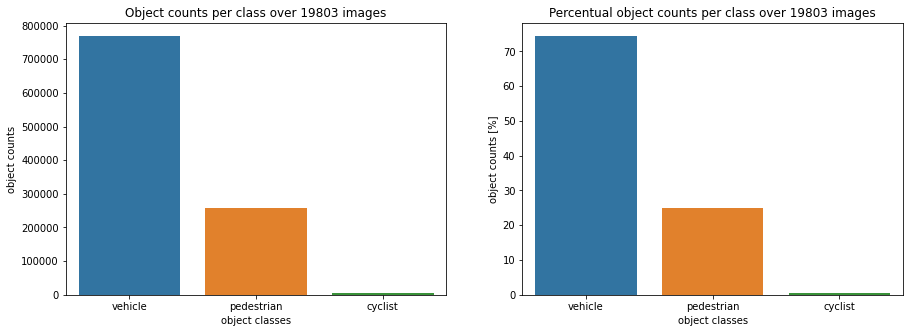

In [10]:
f, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=object_classes, y=object_counts, palette=custom_color_palette, ax=axs[0])
axs[0].set(
    xlabel='object classes',
    ylabel='object counts',
    title='Object counts per class over {} images'.format(total_num_of_frames),
);
sns.barplot(x=object_classes, y=object_percentage, palette=custom_color_palette, ax=axs[1])
axs[1].set(
    xlabel='object classes',
    ylabel='object counts [%]',
    title='Percentual object counts per class over {} images'.format(total_num_of_frames),
);

Percentage of vehicles   = 74.42 %
Percentage of pedestrian = 25.03 %
Percentage of cyclists   =  0.55 %


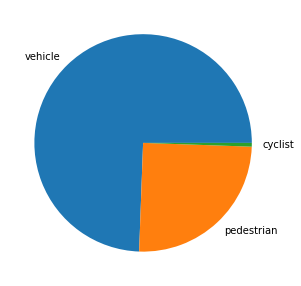

In [11]:
# plot pie graph
f, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.pie(object_counts, labels=object_classes, colors=custom_colors)

# calculate distribution percentage
print("Percentage of vehicles   = {0:5.2f} %".format(object_percentage[0]))
print("Percentage of pedestrian = {0:5.2f} %".format(object_percentage[1]))
print("Percentage of cyclists   = {0:5.2f} %".format(object_percentage[2]))

### Frame counts per time of day, location and weather conditions

In [12]:
# Frame counts per time of day, location and weather condition
frame_counts_by_time_of_day = df_frame_stats.time_of_day.value_counts()
frame_counts_by_location = df_frame_stats.location.value_counts()
frame_counts_by_weather = df_frame_stats.weather.value_counts()

# Print results
print("\nFrame counts by time of day:\n{}".format(frame_counts_by_time_of_day))
print("\nFrame counts by loation:\n{}".format(frame_counts_by_time_of_day))
print("\nFrame counts by weather:\n{}".format(frame_counts_by_time_of_day))


Frame counts by time of day:
Day          16665
Night         1574
Dawn/Dusk     1564
Name: time_of_day, dtype: int64

Frame counts by loation:
Day          16665
Night         1574
Dawn/Dusk     1564
Name: time_of_day, dtype: int64

Frame counts by weather:
Day          16665
Night         1574
Dawn/Dusk     1564
Name: time_of_day, dtype: int64


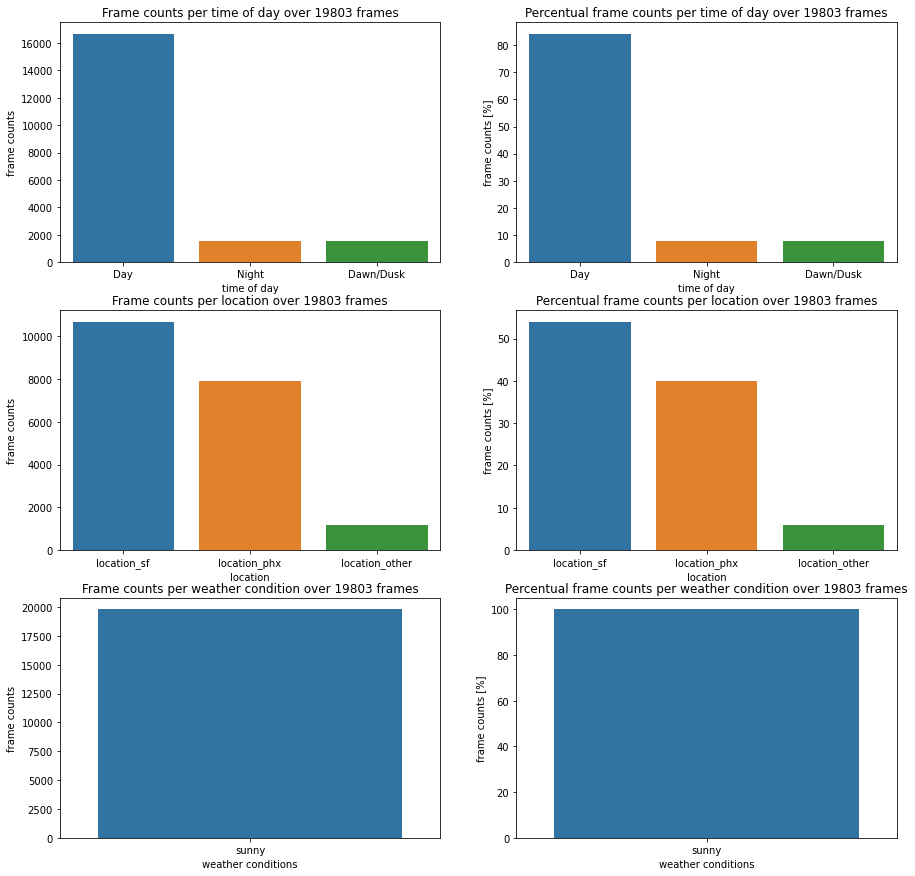

In [13]:
# Plot distribution of time of day, location and weather conditions over all frames in the data set
f, axs = plt.subplots(3, 2, figsize=(15, 15))
sns.barplot(
    x=frame_counts_by_time_of_day.index, y=frame_counts_by_time_of_day,
    palette=custom_color_palette, ax=axs[0, 0]
)
axs[0, 0].set(
    xlabel='time of day',
    ylabel='frame counts',
    title='Frame counts per time of day over {} frames'.format(total_num_of_frames),
);
sns.barplot(
    x=frame_counts_by_time_of_day.index, y=frame_counts_by_time_of_day/total_num_of_frames*100,
    palette=custom_color_palette, ax=axs[0, 1]
)
axs[0, 1].set(
    xlabel='time of day',
    ylabel='frame counts [%]',
    title='Percentual frame counts per time of day over {} frames'.format(total_num_of_frames),
);
sns.barplot(
    x=frame_counts_by_location.index, y=frame_counts_by_location,
    palette=custom_color_palette, ax=axs[1, 0]
)
axs[1, 0].set(
    xlabel='location',
    ylabel='frame counts',
    title='Frame counts per location over {} frames'.format(total_num_of_frames),
);
sns.barplot(
    x=frame_counts_by_location.index, y=frame_counts_by_location/total_num_of_frames*100,
    palette=custom_color_palette, ax=axs[1, 1]
)
axs[1, 1].set(
    xlabel='location',
    ylabel='frame counts [%]',
    title='Percentual frame counts per location over {} frames'.format(total_num_of_frames),
);
sns.barplot(
    x=frame_counts_by_weather.index, y=frame_counts_by_weather,
    palette=custom_color_palette, ax=axs[2, 0]
)
axs[2, 0].set(
    xlabel='weather conditions',
    ylabel='frame counts',
    title='Frame counts per weather condition over {} frames'.format(total_num_of_frames),
);
sns.barplot(
    x=frame_counts_by_weather.index, y=frame_counts_by_weather/total_num_of_frames*100,
    palette=custom_color_palette, ax=axs[2, 1]
)
axs[2, 1].set(
    xlabel='weather conditions',
    ylabel='frame counts [%]',
    title='Percentual frame counts per weather condition over {} frames'.format(total_num_of_frames),
);

### Object class frequency per frame

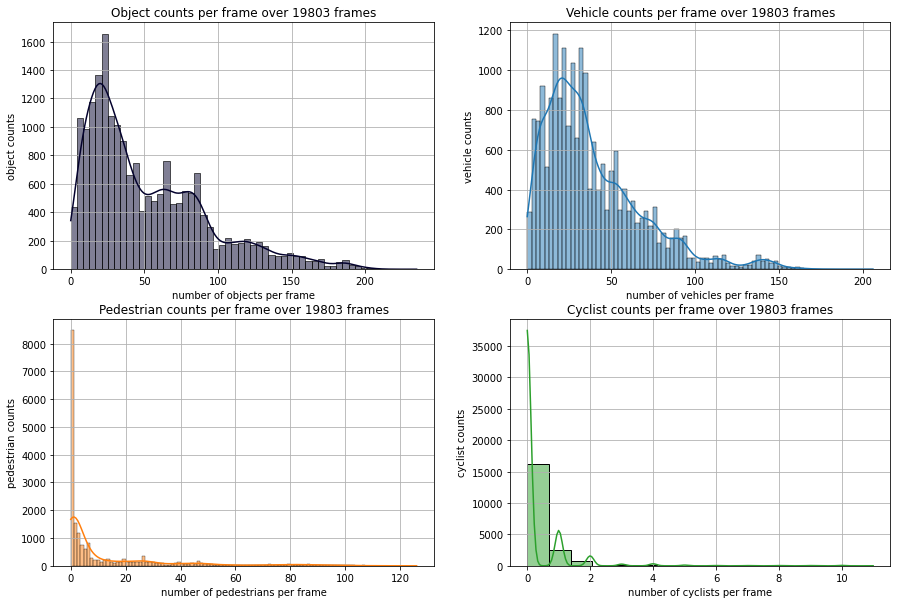

In [14]:
# Plot histograms of object counts per frame over all frames in the data set
f, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(
    data=(df_frame_stats.num_of_vehicles + df_frame_stats.num_of_pedestrians + df_frame_stats.num_of_cyclists),
    kde=True, color="#03012d", ax=axs[0, 0])
axs[0, 0].grid()
axs[0, 0].set(
    xlabel='number of objects per frame',
    ylabel='object counts',
    title='Object counts per frame over {} frames'.format(total_num_of_frames),
);
sns.histplot(
    data=df_frame_stats.num_of_vehicles,
    kde=True, color=custom_colors[0], ax=axs[0, 1]
)
axs[0, 1].grid()
axs[0, 1].set(
    xlabel='number of vehicles per frame',
    ylabel='vehicle counts',
    title='Vehicle counts per frame over {} frames'.format(total_num_of_frames),
);
sns.histplot(
    data=df_frame_stats.num_of_pedestrians,
    kde=True, color=custom_colors[1], ax=axs[1, 0]
)
axs[1, 0].grid()
axs[1, 0].set(
    xlabel='number of pedestrians per frame',
    ylabel='pedestrian counts',
    title='Pedestrian counts per frame over {} frames'.format(total_num_of_frames),
);
sns.histplot(
    data=df_frame_stats.num_of_cyclists,
    kde=True, color=custom_colors[2],ax=axs[1, 1]
)
axs[1, 1].grid()
axs[1, 1].set(
    xlabel='number of cyclists per frame',
    ylabel='cyclist counts',
    title='Cyclist counts per frame over {} frames'.format(total_num_of_frames),
);

## Analyse and Compare Training, Validation and Test Data Sub-Sets

In [15]:
# get filenames of the training data set
train_file_list = 'tfrecord_files_train.txt'
with open(train_file_list, 'r') as f:
    train_filenames = f.read().splitlines()

# get filenames of the validation data set
val_file_list = 'tfrecord_files_val.txt'
with open(val_file_list, 'r') as f:
    val_filenames = f.read().splitlines()

# get filenames of the test data set
test_file_list = 'tfrecord_files_test.txt'
with open(test_file_list, 'r') as f:
    test_filenames = f.read().splitlines()

In [16]:
# extract the tfrecord context ids from the filenames belonging to the training, validation and test data set
train_tfrecord_ids = [fn.replace('segment-', '').replace('_with_camera_labels.tfrecord', '') for fn in train_filenames]
val_tfrecord_ids = [fn.replace('segment-', '').replace('_with_camera_labels.tfrecord', '') for fn in val_filenames]
test_tfrecord_ids = [fn.replace('segment-', '').replace('_with_camera_labels.tfrecord', '') for fn in test_filenames]

In [17]:
# create separate data frames for the statistics of the training, validation and test data set
df_frame_stats_train = df_frame_stats[df_frame_stats['tfrecord_id'].isin(train_tfrecord_ids)]
df_frame_stats_val = df_frame_stats[df_frame_stats['tfrecord_id'].isin(val_tfrecord_ids)]
df_frame_stats_test = df_frame_stats[df_frame_stats['tfrecord_id'].isin(test_tfrecord_ids)]

### Frame counts per data sub-set

In [18]:
# get the number of frames in the training, validation and test data set (without applying downsampling)
num_of_frames_train = len(df_frame_stats_train)
num_of_frames_val = len(df_frame_stats_val)
num_of_frames_test = len(df_frame_stats_test)
# Print results
print('Total number of frames in the data sets (without applying downsampling):')
print("- Number of frames in the training set: {0}".format(num_of_frames_train))
print("- Number of frames in the validation set: {0}".format(num_of_frames_val))
print("- Number of frames in the test set: {0}".format(num_of_frames_test))
print("- Total number of frames: {0}".format(total_num_of_frames))

Total number of frames in the data sets (without applying downsampling):
- Number of frames in the training set: 16230
- Number of frames in the validation set: 2977
- Number of frames in the test set: 596
- Total number of frames: 19803


### Frame counts per time of day

In [19]:
# Frame counts per time of day for training, validation and test data set (without applying downsampling)
time_of_day_classes_train = df_frame_stats_train.time_of_day.unique()
frame_counts_by_time_of_day_train = df_frame_stats_train.time_of_day.value_counts().to_numpy()
time_of_day_classes_val = df_frame_stats_val.time_of_day.unique()
frame_counts_by_time_of_day_val = df_frame_stats_val.time_of_day.value_counts().to_numpy()
time_of_day_classes_test = df_frame_stats_test.time_of_day.unique()
frame_counts_by_time_of_day_test = df_frame_stats_test.time_of_day.value_counts().to_numpy()

# Print results
print("\nFrame counts by time of day (without applying downsampling):\n")
print("Training data set:\n{}\n{}\n".format(time_of_day_classes_train, frame_counts_by_time_of_day_train))
print("Validation data set:\n{}\n{}\n".format(time_of_day_classes_val, frame_counts_by_time_of_day_val))
print("Test data set:\n{}\n{}\n".format(time_of_day_classes_test, frame_counts_by_time_of_day_test))


Frame counts by time of day (without applying downsampling):

Training data set:
['Day' 'Dawn/Dusk' 'Night']
[13489  1564  1177]

Validation data set:
['Day' 'Night']
[2779  198]

Test data set:
['Day' 'Night']
[397 199]



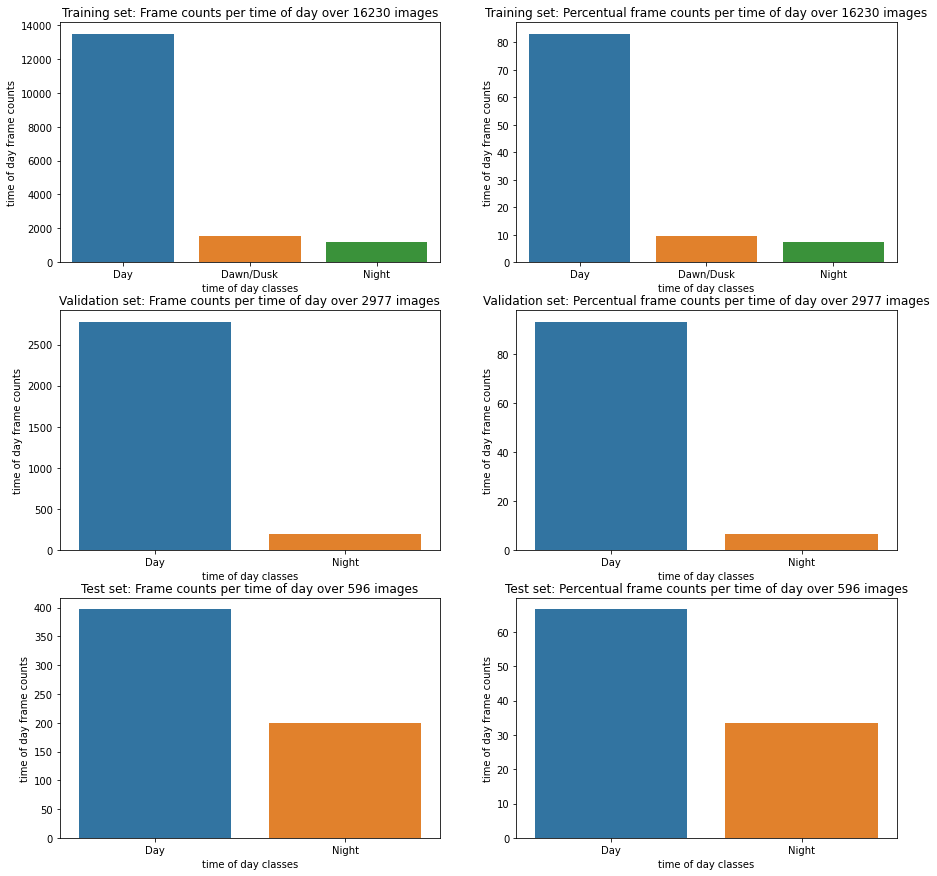

In [20]:
f, axs = plt.subplots(3, 2, figsize=(15, 15))
sns.barplot(x=time_of_day_classes_train, y=frame_counts_by_time_of_day_train,
            palette=custom_color_palette, ax=axs[0, 0])
axs[0, 0].set(
    xlabel='time of day classes',
    ylabel='time of day frame counts',
    title='Training set: Frame counts per time of day over {} images'.format(
        num_of_frames_train),
);
sns.barplot(x=time_of_day_classes_train, y=frame_counts_by_time_of_day_train/num_of_frames_train*100,
            palette=custom_color_palette, ax=axs[0, 1])
axs[0, 1].set(
    xlabel='time of day classes',
    ylabel='time of day frame counts',
    title='Training set: Percentual frame counts per time of day over {} images'.format(
        num_of_frames_train),
);
sns.barplot(x=time_of_day_classes_val, y=frame_counts_by_time_of_day_val,
            palette=custom_color_palette, ax=axs[1, 0])
axs[1, 0].set(
    xlabel='time of day classes',
    ylabel='time of day frame counts',
    title='Validation set: Frame counts per time of day over {} images'.format(
        num_of_frames_val),
);
sns.barplot(x=time_of_day_classes_val, y=frame_counts_by_time_of_day_val/num_of_frames_val*100,
            palette=custom_color_palette, ax=axs[1, 1])
axs[1, 1].set(
    xlabel='time of day classes',
    ylabel='time of day frame counts',
    title='Validation set: Percentual frame counts per time of day over {} images'.format(
        num_of_frames_val),
);
sns.barplot(x=time_of_day_classes_test, y=frame_counts_by_time_of_day_test,
            palette=custom_color_palette, ax=axs[2, 0])
axs[2, 0].set(
    xlabel='time of day classes',
    ylabel='time of day frame counts',
    title='Test set: Frame counts per time of day over {} images'.format(
        num_of_frames_test),
);
sns.barplot(x=time_of_day_classes_test, y=frame_counts_by_time_of_day_test/num_of_frames_test*100,
            palette=custom_color_palette, ax=axs[2, 1])
axs[2, 1].set(
    xlabel='time of day classes',
    ylabel='time of day frame counts',
    title='Test set: Percentual frame counts per time of day over {} images'.format(
        num_of_frames_test),
);

### Object classes and object counts

In [21]:
# get total number of labeled objects in the training data set
object_counts_train = [
    df_frame_stats_train.num_of_vehicles.sum(),
    df_frame_stats_train.num_of_pedestrians.sum(),
    df_frame_stats_train.num_of_cyclists.sum()
]
object_percentage_train = np.array(object_counts_train) / sum(object_counts_train) * 100
# Print results
print('Total number of labeled objects in the training data set:')
print("- Vehicles: {0} ({1:5.2f}%)".format(object_counts_train[0], object_percentage_train[0]))
print("- Pedestrians: {0} ({1:5.2f}%)".format(object_counts_train[1], object_percentage_train[1]))
print("- Cyclists: {0} ({1:5.2f}%)".format(object_counts_train[2], object_percentage_train[2]))
print("- Objects: {0} (100%)".format(sum(object_counts_train)))
print("")
# get total number of labeled objects in the validation data set
object_counts_val = [
    df_frame_stats_val.num_of_vehicles.sum(),
    df_frame_stats_val.num_of_pedestrians.sum(),
    df_frame_stats_val.num_of_cyclists.sum()
]
object_percentage_val = np.array(object_counts_val) / sum(object_counts_val) * 100
# Print results
print('Total number of labeled objects in the validation data set:')
print("- Vehicles: {0} ({1:5.2f}%)".format(object_counts_val[0], object_percentage_val[0]))
print("- Pedestrians: {0} ({1:5.2f}%)".format(object_counts_val[1], object_percentage_val[1]))
print("- Cyclists: {0} ({1:5.2f}%)".format(object_counts_val[2], object_percentage_val[2]))
print("- Objects: {0} (100%)".format(sum(object_counts_val)))
print("")
# get total number of labeled objects in the test data set
object_counts_test = [
    df_frame_stats_test.num_of_vehicles.sum(),
    df_frame_stats_test.num_of_pedestrians.sum(),
    df_frame_stats_test.num_of_cyclists.sum()
]
object_percentage_test = np.array(object_counts_test) / sum(object_counts_test) * 100
# Print results
print('Total number of labeled objects in the test data set:')
print("- Vehicles: {0} ({1:5.2f}%)".format(object_counts_test[0], object_percentage_test[0]))
print("- Pedestrians: {0} ({1:5.2f}%)".format(object_counts_test[1], object_percentage_test[1]))
print("- Cyclists: {0} ({1:5.2f}%)".format(object_counts_test[2], object_percentage_test[2]))
print("- Objects: {0} (100%)".format(sum(object_counts_test)))

Total number of labeled objects in the training data set:
- Vehicles: 643732 (75.43%)
- Pedestrians: 205188 (24.04%)
- Cyclists: 4527 ( 0.53%)
- Objects: 853447 (100%)

Total number of labeled objects in the validation data set:
- Vehicles: 106286 (66.97%)
- Pedestrians: 51210 (32.27%)
- Cyclists: 1205 ( 0.76%)
- Objects: 158701 (100%)

Total number of labeled objects in the test data set:
- Vehicles: 19084 (89.48%)
- Pedestrians: 2244 (10.52%)
- Cyclists: 0 ( 0.00%)
- Objects: 21328 (100%)


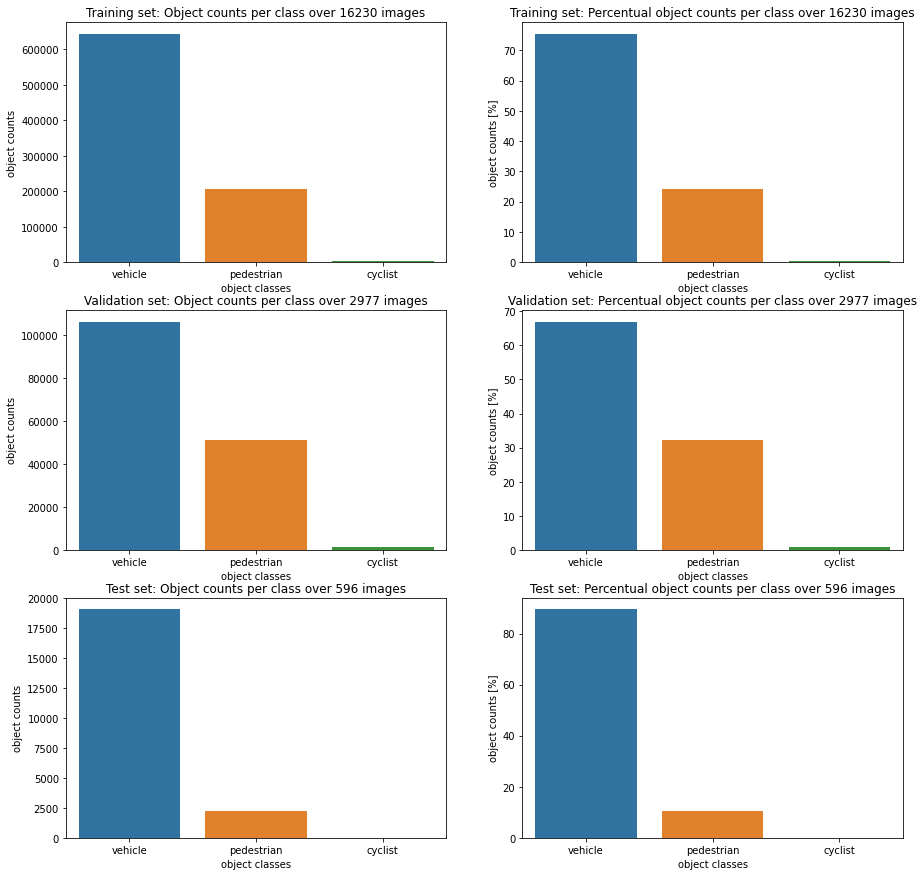

In [22]:
f, axs = plt.subplots(3, 2, figsize=(15, 15))
sns.barplot(x=object_classes, y=object_counts_train, palette=custom_color_palette, ax=axs[0, 0])
axs[0, 0].set(
    xlabel='object classes',
    ylabel='object counts',
    title='Training set: Object counts per class over {} images'.format(num_of_frames_train),
);
sns.barplot(x=object_classes, y=object_percentage_train, palette=custom_color_palette, ax=axs[0, 1])
axs[0, 1].set(
    xlabel='object classes',
    ylabel='object counts [%]',
    title='Training set: Percentual object counts per class over {} images'.format(num_of_frames_train),
);
sns.barplot(x=object_classes, y=object_counts_val, palette=custom_color_palette, ax=axs[1, 0])
axs[1, 0].set(
    xlabel='object classes',
    ylabel='object counts',
    title='Validation set: Object counts per class over {} images'.format(num_of_frames_val),
);
sns.barplot(x=object_classes, y=object_percentage_val, palette=custom_color_palette, ax=axs[1, 1])
axs[1, 1].set(
    xlabel='object classes',
    ylabel='object counts [%]',
    title='Validation set: Percentual object counts per class over {} images'.format(num_of_frames_val),
);
sns.barplot(x=object_classes, y=object_counts_test, palette=custom_color_palette, ax=axs[2, 0])
axs[2, 0].set(
    xlabel='object classes',
    ylabel='object counts',
    title='Test set: Object counts per class over {} images'.format(num_of_frames_test),
);
sns.barplot(x=object_classes, y=object_percentage_test, palette=custom_color_palette, ax=axs[2, 1])
axs[2, 1].set(
    xlabel='object classes',
    ylabel='object counts [%]',
    title='Test set: Percentual object counts per class over {} images'.format(num_of_frames_test),
);

### Object class frequency per frame

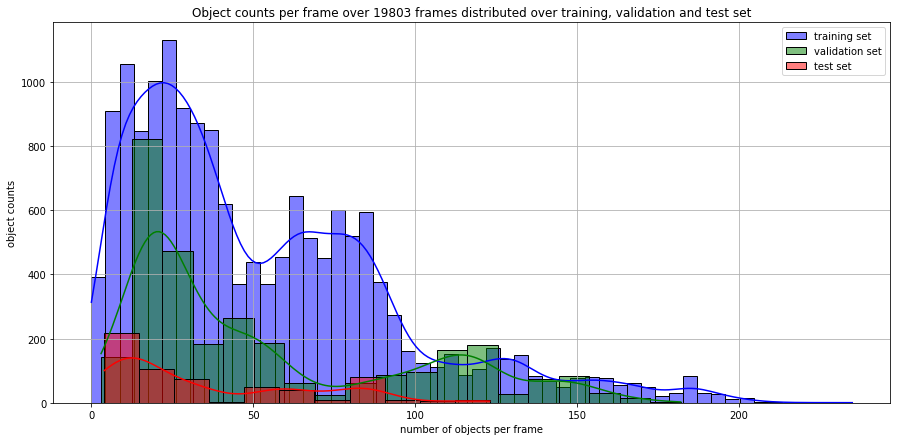

In [23]:
# Plot histograms of object counts per frame over all frames in the data set
f, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.histplot(
    data=(df_frame_stats_train.num_of_vehicles + \
          df_frame_stats_train.num_of_pedestrians + \
          df_frame_stats_train.num_of_cyclists),
    kde=True, color="blue", label="training set", ax=ax)
sns.histplot(
    data=(df_frame_stats_val.num_of_vehicles + \
          df_frame_stats_val.num_of_pedestrians + \
          df_frame_stats_val.num_of_cyclists),
    kde=True, color="green", label="validation set", ax=ax)
sns.histplot(
    data=(df_frame_stats_test.num_of_vehicles + \
          df_frame_stats_test.num_of_pedestrians + \
          df_frame_stats_test.num_of_cyclists),
    kde=True, color="red", label="test set", ax=ax)
ax.set(
    xlabel='number of objects per frame',
    ylabel='object counts',
    title='Object counts per frame over {} frames distributed over training, validation and test set'.format(
        total_num_of_frames),
)
ax.grid()
ax.legend();

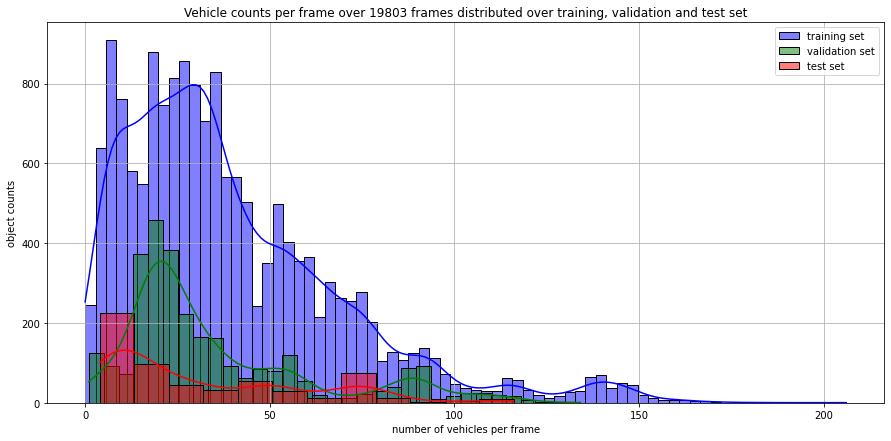

In [24]:
# Plot histograms of vehicle counts per frame over all frames in the data set
f, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.histplot(
    data=df_frame_stats_train.num_of_vehicles,
    kde=True, color="blue", label="training set", ax=ax)
sns.histplot(
    data=df_frame_stats_val.num_of_vehicles,
    kde=True, color="green", label="validation set", ax=ax)
sns.histplot(
    data=df_frame_stats_test.num_of_vehicles,
    kde=True, color="red", label="test set", ax=ax)
ax.set(
    xlabel='number of vehicles per frame',
    ylabel='object counts',
    title='Vehicle counts per frame over {} frames distributed over training, validation and test set'.format(
        total_num_of_frames),
)
ax.grid()
ax.legend();

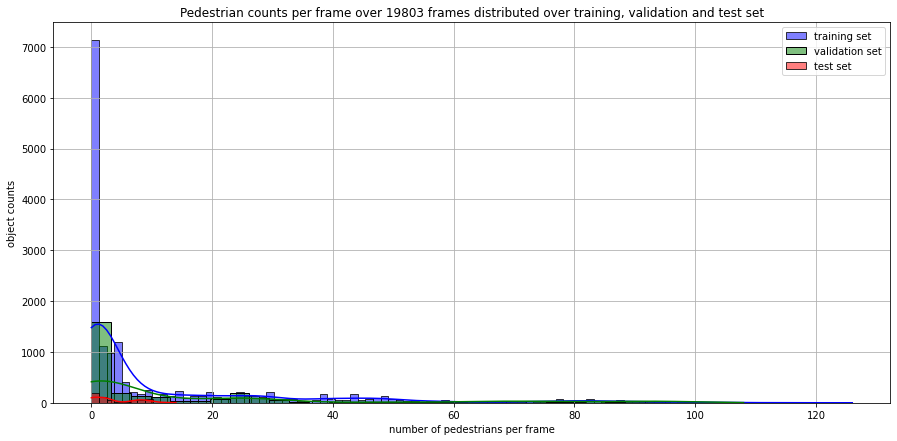

In [25]:
# Plot histograms of object counts per frame over all frames in the data set
f, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.histplot(
    data=df_frame_stats_train.num_of_pedestrians,
    kde=True, color="blue", label="training set", ax=ax)
sns.histplot(
    data=df_frame_stats_val.num_of_pedestrians,
    kde=True, color="green", label="validation set", ax=ax)
sns.histplot(
    data=df_frame_stats_test.num_of_pedestrians,
    kde=True, color="red", label="test set", ax=ax)
ax.set(
    xlabel='number of pedestrians per frame',
    ylabel='object counts',
    title='Pedestrian counts per frame over {} frames distributed over training, validation and test set'.format(
        total_num_of_frames),
)
ax.grid()
ax.legend();

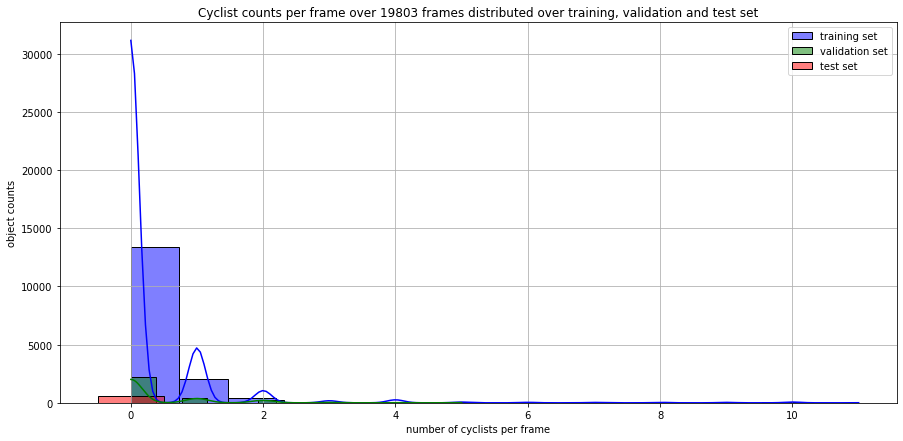

In [26]:
# Plot histograms of object counts per frame over all frames in the data set
f, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.histplot(
    data=df_frame_stats_train.num_of_cyclists,
    kde=True, color="blue", label="training set", ax=ax)
sns.histplot(
    data=df_frame_stats_val.num_of_cyclists,
    kde=True, color="green", label="validation set", ax=ax)
sns.histplot(
    data=df_frame_stats_test.num_of_cyclists,
    kde=True, color="red", label="test set", ax=ax)
ax.set(
    xlabel='number of cyclists per frame',
    ylabel='object counts',
    title='Cyclist counts per frame over {} frames distributed over training, validation and test set'.format(
        total_num_of_frames),
)
ax.grid()
ax.legend();